<a href="https://colab.research.google.com/github/cotton-ahn/TUM_20WS_Intro2Deep/blob/main/Lecture9_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.7.0+cu101


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = (img / 255) * 2 - 1
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


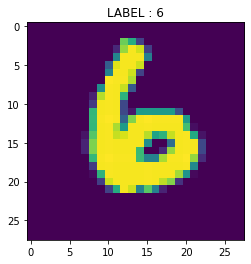

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the GAN (Generator + Discriminator)


In [ ]:
class Generator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(Generator, self).__init__()
        
        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define generator
        self.fc_1 = nn.Linear(dim_z, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, dim_input)
        self.bn_1 = nn.BatchNorm1d(dim_hidden_1)
        self.bn_2 = nn.BatchNorm1d(dim_hidden_2)
    
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        out = self.activation(self.bn_1(self.fc_1(z)))
        out = self.activation(self.bn_2(self.fc_2(out)))
        out = torch.tanh(self.fc_3(out))
        
        return out

class Discriminator(nn.Module):
    def __init__(self, dim_hidden_1,dim_input=img_size**2):
        super(Discriminator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input

        # define discriminator
        self.fc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, 1)

        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x needs to be flatted into B by D
        out = self.activation(self.fc_1(x))
        out = self.activation(self.fc_2(out))
        out = self.fc_3(out)

        return torch.sigmoid(out).squeeze(1)


### Define the Model

In [ ]:
dim_hidden_1 = 256
dim_hidden_2 = 512
dim_z = 128
generator = Generator(dim_hidden_1, dim_hidden_2, dim_z).to(device)
discriminator = Discriminator(dim_hidden_1).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=784, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


### Define functions for train/test

In [ ]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    batch_size = sample['img'].shape[0]

    criterion = nn.BCELoss()
    real_label = torch.ones(batch_size).to(device)
    fake_label = torch.zeros(batch_size).to(device)

    sample_z = torch.randn(batch_size, dim_z).to(device)
    real_img = sample['img'].float().to(device).view(batch_size, -1)
    fake_img = generator(sample_z)

    # Train Generator
    generator.train()
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label)

    g_loss.backward()
    gen_optimizer.step()
    
    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label)
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()    

    return g_loss.item(), d_loss.item()    
    

In [ ]:
def test(generator, img_size, dim_z):
    generator.eval()
    with torch.no_grad():
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training

[EPOCH 0] SAMPLED G LOSS : 0.7009545564651489, SAMPLED D LOSS : 0.6820023059844971
[EPOCH 0] SAMPLED G LOSS : 0.5538067817687988, SAMPLED D LOSS : 0.5466035008430481


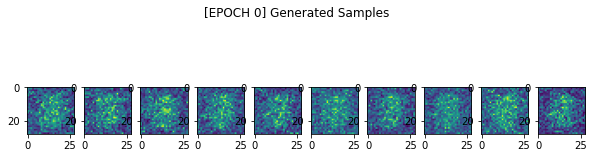

[EPOCH 1] SAMPLED G LOSS : 0.5401228666305542, SAMPLED D LOSS : 0.615209698677063
[EPOCH 1] SAMPLED G LOSS : 0.5779162645339966, SAMPLED D LOSS : 0.644758939743042
[EPOCH 2] SAMPLED G LOSS : 0.6072009801864624, SAMPLED D LOSS : 0.6396433115005493
[EPOCH 2] SAMPLED G LOSS : 0.6700534820556641, SAMPLED D LOSS : 0.6029969453811646
[EPOCH 3] SAMPLED G LOSS : 0.6945751905441284, SAMPLED D LOSS : 0.5807124376296997
[EPOCH 3] SAMPLED G LOSS : 0.6734896302223206, SAMPLED D LOSS : 0.5994237065315247
[EPOCH 4] SAMPLED G LOSS : 0.6772146224975586, SAMPLED D LOSS : 0.5791400671005249
[EPOCH 4] SAMPLED G LOSS : 0.7095986604690552, SAMPLED D LOSS : 0.5696607828140259
[EPOCH 5] SAMPLED G LOSS : 0.7397670745849609, SAMPLED D LOSS : 0.5460364818572998
[EPOCH 5] SAMPLED G LOSS : 0.7504249215126038, SAMPLED D LOSS : 0.5271481275558472
[EPOCH 6] SAMPLED G LOSS : 0.7819902896881104, SAMPLED D LOSS : 0.5090771317481995
[EPOCH 6] SAMPLED G LOSS : 0.9201359748840332, SAMPLED D LOSS : 0.5198031067848206
[EPOCH

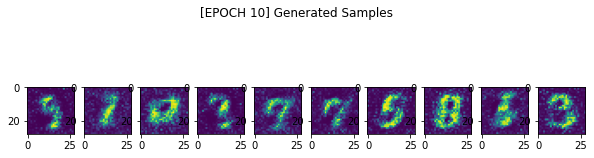

[EPOCH 11] SAMPLED G LOSS : 0.9362362027168274, SAMPLED D LOSS : 0.45472368597984314
[EPOCH 11] SAMPLED G LOSS : 1.0837125778198242, SAMPLED D LOSS : 0.42246687412261963
[EPOCH 12] SAMPLED G LOSS : 1.2759137153625488, SAMPLED D LOSS : 0.4697154462337494
[EPOCH 12] SAMPLED G LOSS : 0.9951549768447876, SAMPLED D LOSS : 0.44266360998153687
[EPOCH 13] SAMPLED G LOSS : 1.1826765537261963, SAMPLED D LOSS : 0.4691959023475647
[EPOCH 13] SAMPLED G LOSS : 1.0990084409713745, SAMPLED D LOSS : 0.4586038291454315
[EPOCH 14] SAMPLED G LOSS : 1.1418792009353638, SAMPLED D LOSS : 0.4513518512248993
[EPOCH 14] SAMPLED G LOSS : 1.2240219116210938, SAMPLED D LOSS : 0.44755515456199646
[EPOCH 15] SAMPLED G LOSS : 1.1366384029388428, SAMPLED D LOSS : 0.45246753096580505
[EPOCH 15] SAMPLED G LOSS : 0.988585352897644, SAMPLED D LOSS : 0.45906978845596313
[EPOCH 16] SAMPLED G LOSS : 1.1559154987335205, SAMPLED D LOSS : 0.47588175535202026
[EPOCH 16] SAMPLED G LOSS : 0.931505560874939, SAMPLED D LOSS : 0.4568

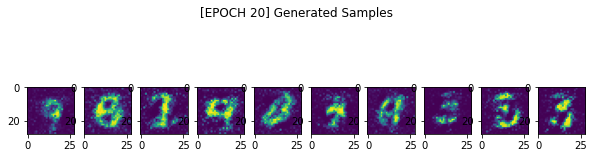

[EPOCH 21] SAMPLED G LOSS : 0.9532449245452881, SAMPLED D LOSS : 0.44598665833473206
[EPOCH 21] SAMPLED G LOSS : 1.1046117544174194, SAMPLED D LOSS : 0.46379658579826355
[EPOCH 22] SAMPLED G LOSS : 1.228122353553772, SAMPLED D LOSS : 0.44528478384017944
[EPOCH 22] SAMPLED G LOSS : 1.139770269393921, SAMPLED D LOSS : 0.47588032484054565
[EPOCH 23] SAMPLED G LOSS : 0.8457016944885254, SAMPLED D LOSS : 0.4992886185646057
[EPOCH 23] SAMPLED G LOSS : 1.0642871856689453, SAMPLED D LOSS : 0.5125265717506409
[EPOCH 24] SAMPLED G LOSS : 0.9962905645370483, SAMPLED D LOSS : 0.4972248077392578
[EPOCH 24] SAMPLED G LOSS : 0.9401795864105225, SAMPLED D LOSS : 0.543636679649353
[EPOCH 25] SAMPLED G LOSS : 1.1994593143463135, SAMPLED D LOSS : 0.5195724964141846
[EPOCH 25] SAMPLED G LOSS : 0.8387590050697327, SAMPLED D LOSS : 0.5184170007705688
[EPOCH 26] SAMPLED G LOSS : 1.1195305585861206, SAMPLED D LOSS : 0.4890778660774231
[EPOCH 26] SAMPLED G LOSS : 1.032310128211975, SAMPLED D LOSS : 0.511927366

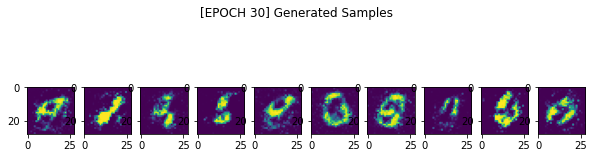

[EPOCH 31] SAMPLED G LOSS : 1.1921613216400146, SAMPLED D LOSS : 0.48186051845550537
[EPOCH 31] SAMPLED G LOSS : 1.2582688331604004, SAMPLED D LOSS : 0.47523993253707886
[EPOCH 32] SAMPLED G LOSS : 1.0996999740600586, SAMPLED D LOSS : 0.5281156301498413
[EPOCH 32] SAMPLED G LOSS : 1.103701114654541, SAMPLED D LOSS : 0.5108551383018494
[EPOCH 33] SAMPLED G LOSS : 0.9579799175262451, SAMPLED D LOSS : 0.5076175332069397
[EPOCH 33] SAMPLED G LOSS : 0.8485618829727173, SAMPLED D LOSS : 0.49266496300697327
[EPOCH 34] SAMPLED G LOSS : 1.273884892463684, SAMPLED D LOSS : 0.5299001336097717
[EPOCH 34] SAMPLED G LOSS : 1.1941723823547363, SAMPLED D LOSS : 0.5133250951766968
[EPOCH 35] SAMPLED G LOSS : 0.9183829426765442, SAMPLED D LOSS : 0.5286697745323181
[EPOCH 35] SAMPLED G LOSS : 0.9398337602615356, SAMPLED D LOSS : 0.4902956187725067
[EPOCH 36] SAMPLED G LOSS : 0.7404499053955078, SAMPLED D LOSS : 0.5620169639587402
[EPOCH 36] SAMPLED G LOSS : 1.1117842197418213, SAMPLED D LOSS : 0.49446719

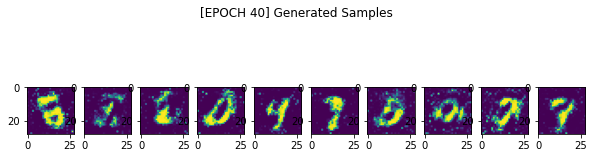

[EPOCH 41] SAMPLED G LOSS : 1.063232660293579, SAMPLED D LOSS : 0.5384321212768555
[EPOCH 41] SAMPLED G LOSS : 1.0131895542144775, SAMPLED D LOSS : 0.4794149398803711
[EPOCH 42] SAMPLED G LOSS : 1.145850419998169, SAMPLED D LOSS : 0.5014057159423828
[EPOCH 42] SAMPLED G LOSS : 1.0152050256729126, SAMPLED D LOSS : 0.5037517547607422
[EPOCH 43] SAMPLED G LOSS : 0.9480072855949402, SAMPLED D LOSS : 0.5392512083053589
[EPOCH 43] SAMPLED G LOSS : 1.3400893211364746, SAMPLED D LOSS : 0.5064239501953125
[EPOCH 44] SAMPLED G LOSS : 0.9332574605941772, SAMPLED D LOSS : 0.5621944665908813
[EPOCH 44] SAMPLED G LOSS : 1.0702420473098755, SAMPLED D LOSS : 0.5059726238250732
[EPOCH 45] SAMPLED G LOSS : 1.0002344846725464, SAMPLED D LOSS : 0.5703667998313904
[EPOCH 45] SAMPLED G LOSS : 1.2071573734283447, SAMPLED D LOSS : 0.5457018613815308
[EPOCH 46] SAMPLED G LOSS : 1.476731300354004, SAMPLED D LOSS : 0.5532806515693665
[EPOCH 46] SAMPLED G LOSS : 0.9351866245269775, SAMPLED D LOSS : 0.541065812110

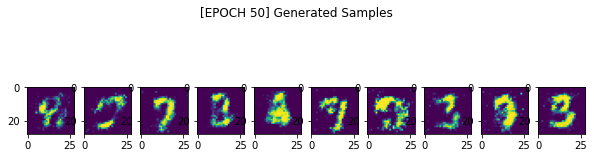

[EPOCH 51] SAMPLED G LOSS : 0.8560421466827393, SAMPLED D LOSS : 0.5011229515075684
[EPOCH 51] SAMPLED G LOSS : 0.8723388314247131, SAMPLED D LOSS : 0.5090294480323792
[EPOCH 52] SAMPLED G LOSS : 0.7304926514625549, SAMPLED D LOSS : 0.5490531325340271
[EPOCH 52] SAMPLED G LOSS : 0.8546313047409058, SAMPLED D LOSS : 0.5094455480575562
[EPOCH 53] SAMPLED G LOSS : 0.9333774447441101, SAMPLED D LOSS : 0.4883050322532654
[EPOCH 53] SAMPLED G LOSS : 1.0482873916625977, SAMPLED D LOSS : 0.535967230796814
[EPOCH 54] SAMPLED G LOSS : 1.2836004495620728, SAMPLED D LOSS : 0.46701014041900635
[EPOCH 54] SAMPLED G LOSS : 0.8222583532333374, SAMPLED D LOSS : 0.5305765867233276
[EPOCH 55] SAMPLED G LOSS : 0.9989383220672607, SAMPLED D LOSS : 0.5213762521743774
[EPOCH 55] SAMPLED G LOSS : 0.9354308843612671, SAMPLED D LOSS : 0.5125523805618286
[EPOCH 56] SAMPLED G LOSS : 0.49116337299346924, SAMPLED D LOSS : 0.6744564771652222
[EPOCH 56] SAMPLED G LOSS : 1.5279395580291748, SAMPLED D LOSS : 0.61101555

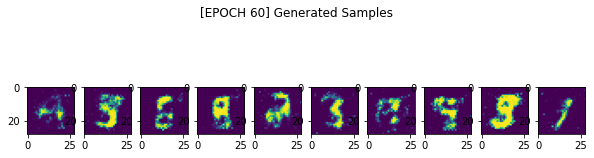

[EPOCH 61] SAMPLED G LOSS : 1.5201091766357422, SAMPLED D LOSS : 0.5449079275131226
[EPOCH 61] SAMPLED G LOSS : 0.9727758169174194, SAMPLED D LOSS : 0.4885176718235016
[EPOCH 62] SAMPLED G LOSS : 1.0263651609420776, SAMPLED D LOSS : 0.5102719068527222
[EPOCH 62] SAMPLED G LOSS : 1.2304832935333252, SAMPLED D LOSS : 0.508443295955658
[EPOCH 63] SAMPLED G LOSS : 0.8984320163726807, SAMPLED D LOSS : 0.5165019631385803
[EPOCH 63] SAMPLED G LOSS : 1.114393949508667, SAMPLED D LOSS : 0.43668004870414734
[EPOCH 64] SAMPLED G LOSS : 1.370999813079834, SAMPLED D LOSS : 0.4838721752166748
[EPOCH 64] SAMPLED G LOSS : 1.0645911693572998, SAMPLED D LOSS : 0.49807679653167725
[EPOCH 65] SAMPLED G LOSS : 0.6237190365791321, SAMPLED D LOSS : 0.5707530975341797
[EPOCH 65] SAMPLED G LOSS : 0.9817577600479126, SAMPLED D LOSS : 0.5136392712593079
[EPOCH 66] SAMPLED G LOSS : 1.1931288242340088, SAMPLED D LOSS : 0.5008771419525146
[EPOCH 66] SAMPLED G LOSS : 0.6626713275909424, SAMPLED D LOSS : 0.5282081365

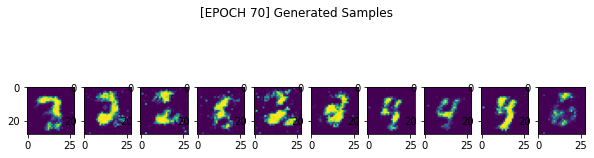

[EPOCH 71] SAMPLED G LOSS : 1.4448397159576416, SAMPLED D LOSS : 0.5585083365440369
[EPOCH 71] SAMPLED G LOSS : 1.0134716033935547, SAMPLED D LOSS : 0.4853177070617676
[EPOCH 72] SAMPLED G LOSS : 0.52264803647995, SAMPLED D LOSS : 0.6109867095947266
[EPOCH 72] SAMPLED G LOSS : 1.0063745975494385, SAMPLED D LOSS : 0.5421544909477234
[EPOCH 73] SAMPLED G LOSS : 1.4686399698257446, SAMPLED D LOSS : 0.6077780723571777
[EPOCH 73] SAMPLED G LOSS : 1.0817593336105347, SAMPLED D LOSS : 0.49917519092559814
[EPOCH 74] SAMPLED G LOSS : 0.8829895853996277, SAMPLED D LOSS : 0.508338212966919
[EPOCH 74] SAMPLED G LOSS : 1.3759816884994507, SAMPLED D LOSS : 0.5573523044586182
[EPOCH 75] SAMPLED G LOSS : 1.2697474956512451, SAMPLED D LOSS : 0.4997037649154663
[EPOCH 75] SAMPLED G LOSS : 1.140480875968933, SAMPLED D LOSS : 0.5077911615371704
[EPOCH 76] SAMPLED G LOSS : 1.145838737487793, SAMPLED D LOSS : 0.47675925493240356
[EPOCH 76] SAMPLED G LOSS : 1.1326022148132324, SAMPLED D LOSS : 0.498658567667

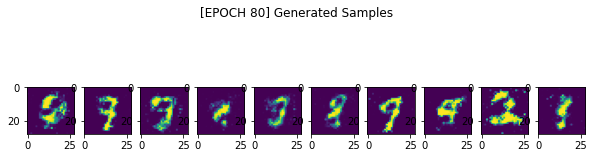

[EPOCH 81] SAMPLED G LOSS : 1.023982048034668, SAMPLED D LOSS : 0.4823795258998871
[EPOCH 81] SAMPLED G LOSS : 1.058476209640503, SAMPLED D LOSS : 0.5505582690238953
[EPOCH 82] SAMPLED G LOSS : 1.71358323097229, SAMPLED D LOSS : 0.6296894550323486
[EPOCH 82] SAMPLED G LOSS : 1.0937526226043701, SAMPLED D LOSS : 0.5089836716651917
[EPOCH 83] SAMPLED G LOSS : 0.9044755697250366, SAMPLED D LOSS : 0.5543146133422852
[EPOCH 83] SAMPLED G LOSS : 0.8676177263259888, SAMPLED D LOSS : 0.5397657155990601
[EPOCH 84] SAMPLED G LOSS : 1.660963773727417, SAMPLED D LOSS : 0.5210373997688293
[EPOCH 84] SAMPLED G LOSS : 0.8682634830474854, SAMPLED D LOSS : 0.5022411346435547
[EPOCH 85] SAMPLED G LOSS : 1.0248446464538574, SAMPLED D LOSS : 0.5062652230262756
[EPOCH 85] SAMPLED G LOSS : 1.0133976936340332, SAMPLED D LOSS : 0.5548933744430542
[EPOCH 86] SAMPLED G LOSS : 0.99550461769104, SAMPLED D LOSS : 0.5488998889923096
[EPOCH 86] SAMPLED G LOSS : 1.0175130367279053, SAMPLED D LOSS : 0.5154694318771362

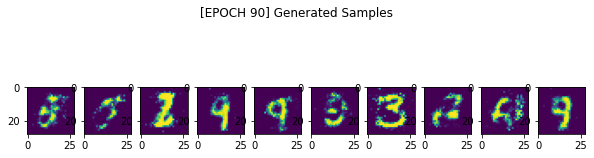

[EPOCH 91] SAMPLED G LOSS : 1.211851716041565, SAMPLED D LOSS : 0.5049219131469727
[EPOCH 91] SAMPLED G LOSS : 1.0058832168579102, SAMPLED D LOSS : 0.5045135021209717
[EPOCH 92] SAMPLED G LOSS : 1.118733286857605, SAMPLED D LOSS : 0.5711367130279541
[EPOCH 92] SAMPLED G LOSS : 0.8396491408348083, SAMPLED D LOSS : 0.5115373134613037
[EPOCH 93] SAMPLED G LOSS : 0.8784951567649841, SAMPLED D LOSS : 0.5702786445617676
[EPOCH 93] SAMPLED G LOSS : 0.9234085083007812, SAMPLED D LOSS : 0.5217154026031494
[EPOCH 94] SAMPLED G LOSS : 0.8313480019569397, SAMPLED D LOSS : 0.5402306318283081
[EPOCH 94] SAMPLED G LOSS : 1.218808889389038, SAMPLED D LOSS : 0.5334764719009399
[EPOCH 95] SAMPLED G LOSS : 0.7139244079589844, SAMPLED D LOSS : 0.547409176826477
[EPOCH 95] SAMPLED G LOSS : 0.7958821058273315, SAMPLED D LOSS : 0.5304279923439026
[EPOCH 96] SAMPLED G LOSS : 0.6414346098899841, SAMPLED D LOSS : 0.5801613330841064
[EPOCH 96] SAMPLED G LOSS : 0.8039895296096802, SAMPLED D LOSS : 0.5261725783348

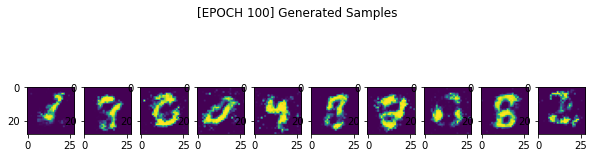

[EPOCH 101] SAMPLED G LOSS : 1.051356554031372, SAMPLED D LOSS : 0.46129217743873596
[EPOCH 101] SAMPLED G LOSS : 0.8046832084655762, SAMPLED D LOSS : 0.6186500191688538
[EPOCH 102] SAMPLED G LOSS : 1.0222045183181763, SAMPLED D LOSS : 0.5380764007568359
[EPOCH 102] SAMPLED G LOSS : 0.8786824941635132, SAMPLED D LOSS : 0.49286019802093506
[EPOCH 103] SAMPLED G LOSS : 1.0080859661102295, SAMPLED D LOSS : 0.5218963623046875
[EPOCH 103] SAMPLED G LOSS : 0.9583967328071594, SAMPLED D LOSS : 0.550281286239624
[EPOCH 104] SAMPLED G LOSS : 1.0102241039276123, SAMPLED D LOSS : 0.5489438772201538
[EPOCH 104] SAMPLED G LOSS : 1.0661063194274902, SAMPLED D LOSS : 0.4792703688144684
[EPOCH 105] SAMPLED G LOSS : 1.2527110576629639, SAMPLED D LOSS : 0.53519207239151
[EPOCH 105] SAMPLED G LOSS : 0.7917828559875488, SAMPLED D LOSS : 0.5360332727432251
[EPOCH 106] SAMPLED G LOSS : 1.1095023155212402, SAMPLED D LOSS : 0.5293450951576233
[EPOCH 106] SAMPLED G LOSS : 1.3415212631225586, SAMPLED D LOSS : 0

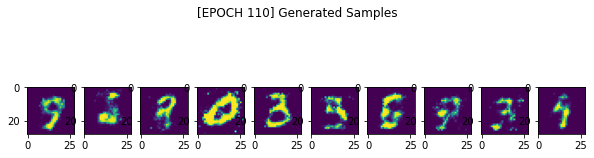

[EPOCH 111] SAMPLED G LOSS : 1.2149288654327393, SAMPLED D LOSS : 0.6012797355651855
[EPOCH 111] SAMPLED G LOSS : 0.7075827121734619, SAMPLED D LOSS : 0.5453808307647705
[EPOCH 112] SAMPLED G LOSS : 1.373178482055664, SAMPLED D LOSS : 0.49559080600738525
[EPOCH 112] SAMPLED G LOSS : 1.6745765209197998, SAMPLED D LOSS : 0.5384020209312439
[EPOCH 113] SAMPLED G LOSS : 0.6630879044532776, SAMPLED D LOSS : 0.5652413964271545
[EPOCH 113] SAMPLED G LOSS : 1.1976642608642578, SAMPLED D LOSS : 0.5731122493743896
[EPOCH 114] SAMPLED G LOSS : 1.3940095901489258, SAMPLED D LOSS : 0.6069852113723755
[EPOCH 114] SAMPLED G LOSS : 1.2284975051879883, SAMPLED D LOSS : 0.5977029800415039
[EPOCH 115] SAMPLED G LOSS : 1.315075159072876, SAMPLED D LOSS : 0.5368824005126953
[EPOCH 115] SAMPLED G LOSS : 1.1382700204849243, SAMPLED D LOSS : 0.49075186252593994
[EPOCH 116] SAMPLED G LOSS : 0.9815732836723328, SAMPLED D LOSS : 0.4782056212425232
[EPOCH 116] SAMPLED G LOSS : 1.057725429534912, SAMPLED D LOSS : 

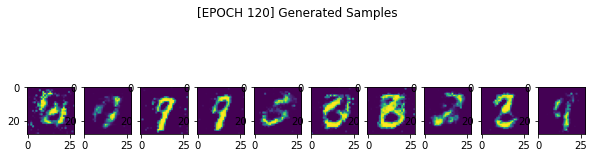

[EPOCH 121] SAMPLED G LOSS : 1.4443588256835938, SAMPLED D LOSS : 0.5665349960327148
[EPOCH 121] SAMPLED G LOSS : 1.3586502075195312, SAMPLED D LOSS : 0.4982776939868927
[EPOCH 122] SAMPLED G LOSS : 1.0052059888839722, SAMPLED D LOSS : 0.4859985113143921
[EPOCH 122] SAMPLED G LOSS : 0.8660961389541626, SAMPLED D LOSS : 0.5801236629486084
[EPOCH 123] SAMPLED G LOSS : 1.0681787729263306, SAMPLED D LOSS : 0.42069411277770996
[EPOCH 123] SAMPLED G LOSS : 1.590526819229126, SAMPLED D LOSS : 0.5615066289901733
[EPOCH 124] SAMPLED G LOSS : 1.0081894397735596, SAMPLED D LOSS : 0.4593591094017029
[EPOCH 124] SAMPLED G LOSS : 1.2623319625854492, SAMPLED D LOSS : 0.5124710202217102
[EPOCH 125] SAMPLED G LOSS : 1.1895968914031982, SAMPLED D LOSS : 0.5321017503738403
[EPOCH 125] SAMPLED G LOSS : 0.9504587054252625, SAMPLED D LOSS : 0.5135536193847656
[EPOCH 126] SAMPLED G LOSS : 0.9594072699546814, SAMPLED D LOSS : 0.5192409157752991
[EPOCH 126] SAMPLED G LOSS : 0.9998688697814941, SAMPLED D LOSS :

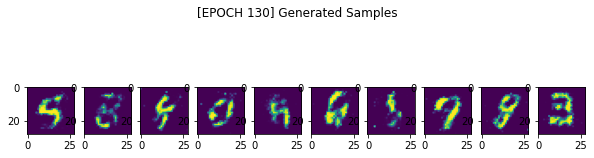

[EPOCH 131] SAMPLED G LOSS : 0.9676324725151062, SAMPLED D LOSS : 0.4852328598499298
[EPOCH 131] SAMPLED G LOSS : 1.6812094449996948, SAMPLED D LOSS : 0.6462280750274658
[EPOCH 132] SAMPLED G LOSS : 1.0973281860351562, SAMPLED D LOSS : 0.5167326927185059
[EPOCH 132] SAMPLED G LOSS : 0.9587637782096863, SAMPLED D LOSS : 0.4713922142982483
[EPOCH 133] SAMPLED G LOSS : 1.0668154954910278, SAMPLED D LOSS : 0.4543936848640442
[EPOCH 133] SAMPLED G LOSS : 0.7777613401412964, SAMPLED D LOSS : 0.553452730178833
[EPOCH 134] SAMPLED G LOSS : 0.8240270018577576, SAMPLED D LOSS : 0.5059266090393066
[EPOCH 134] SAMPLED G LOSS : 1.3004896640777588, SAMPLED D LOSS : 0.47635048627853394
[EPOCH 135] SAMPLED G LOSS : 0.735709547996521, SAMPLED D LOSS : 0.5706606507301331
[EPOCH 135] SAMPLED G LOSS : 0.9140713810920715, SAMPLED D LOSS : 0.49613943696022034
[EPOCH 136] SAMPLED G LOSS : 1.2475063800811768, SAMPLED D LOSS : 0.48627400398254395
[EPOCH 136] SAMPLED G LOSS : 1.1435352563858032, SAMPLED D LOSS 

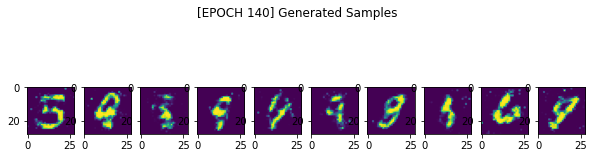

[EPOCH 141] SAMPLED G LOSS : 1.309424877166748, SAMPLED D LOSS : 0.506780743598938
[EPOCH 141] SAMPLED G LOSS : 0.8687048554420471, SAMPLED D LOSS : 0.5513713955879211
[EPOCH 142] SAMPLED G LOSS : 0.7968246936798096, SAMPLED D LOSS : 0.5547141432762146
[EPOCH 142] SAMPLED G LOSS : 1.4993188381195068, SAMPLED D LOSS : 0.6605424880981445
[EPOCH 143] SAMPLED G LOSS : 1.2301687002182007, SAMPLED D LOSS : 0.49281400442123413
[EPOCH 143] SAMPLED G LOSS : 1.0227371454238892, SAMPLED D LOSS : 0.53013676404953
[EPOCH 144] SAMPLED G LOSS : 0.8422770500183105, SAMPLED D LOSS : 0.5537502765655518
[EPOCH 144] SAMPLED G LOSS : 1.029255747795105, SAMPLED D LOSS : 0.5589956045150757
[EPOCH 145] SAMPLED G LOSS : 1.206606149673462, SAMPLED D LOSS : 0.523143470287323
[EPOCH 145] SAMPLED G LOSS : 1.2885692119598389, SAMPLED D LOSS : 0.48259204626083374
[EPOCH 146] SAMPLED G LOSS : 1.0588380098342896, SAMPLED D LOSS : 0.4993482232093811
[EPOCH 146] SAMPLED G LOSS : 0.9521777629852295, SAMPLED D LOSS : 0.51

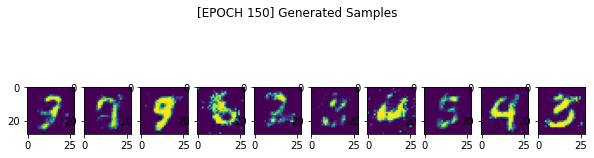

[EPOCH 151] SAMPLED G LOSS : 0.6973006725311279, SAMPLED D LOSS : 0.5544801354408264
[EPOCH 151] SAMPLED G LOSS : 0.9845957159996033, SAMPLED D LOSS : 0.5496877431869507
[EPOCH 152] SAMPLED G LOSS : 0.960243821144104, SAMPLED D LOSS : 0.4707193374633789
[EPOCH 152] SAMPLED G LOSS : 1.5352468490600586, SAMPLED D LOSS : 0.5691078901290894
[EPOCH 153] SAMPLED G LOSS : 1.3668558597564697, SAMPLED D LOSS : 0.4417393207550049
[EPOCH 153] SAMPLED G LOSS : 0.7843529582023621, SAMPLED D LOSS : 0.5691336393356323
[EPOCH 154] SAMPLED G LOSS : 1.334405779838562, SAMPLED D LOSS : 0.576941728591919
[EPOCH 154] SAMPLED G LOSS : 1.1043486595153809, SAMPLED D LOSS : 0.45533984899520874
[EPOCH 155] SAMPLED G LOSS : 0.7749525308609009, SAMPLED D LOSS : 0.5951404571533203
[EPOCH 155] SAMPLED G LOSS : 1.317124605178833, SAMPLED D LOSS : 0.5771191120147705
[EPOCH 156] SAMPLED G LOSS : 1.6504745483398438, SAMPLED D LOSS : 0.521966278553009
[EPOCH 156] SAMPLED G LOSS : 0.9647701978683472, SAMPLED D LOSS : 0.5

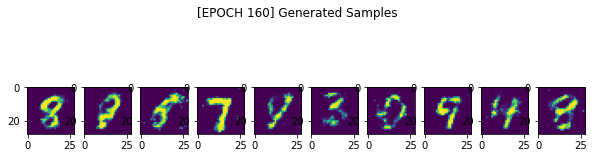

[EPOCH 161] SAMPLED G LOSS : 1.6106960773468018, SAMPLED D LOSS : 0.5363473892211914
[EPOCH 161] SAMPLED G LOSS : 0.9768204092979431, SAMPLED D LOSS : 0.5268794894218445
[EPOCH 162] SAMPLED G LOSS : 0.7654443979263306, SAMPLED D LOSS : 0.567362368106842
[EPOCH 162] SAMPLED G LOSS : 1.2915470600128174, SAMPLED D LOSS : 0.5177769660949707
[EPOCH 163] SAMPLED G LOSS : 0.7851701974868774, SAMPLED D LOSS : 0.5154917240142822
[EPOCH 163] SAMPLED G LOSS : 1.2447292804718018, SAMPLED D LOSS : 0.5058167576789856
[EPOCH 164] SAMPLED G LOSS : 1.2738088369369507, SAMPLED D LOSS : 0.4925832748413086
[EPOCH 164] SAMPLED G LOSS : 1.3118488788604736, SAMPLED D LOSS : 0.4838045537471771
[EPOCH 165] SAMPLED G LOSS : 1.333700180053711, SAMPLED D LOSS : 0.5300420522689819
[EPOCH 165] SAMPLED G LOSS : 0.7647984623908997, SAMPLED D LOSS : 0.5930611491203308
[EPOCH 166] SAMPLED G LOSS : 1.1874585151672363, SAMPLED D LOSS : 0.5387730598449707
[EPOCH 166] SAMPLED G LOSS : 1.4270405769348145, SAMPLED D LOSS : 0

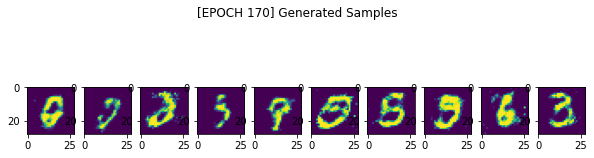

[EPOCH 171] SAMPLED G LOSS : 0.8681574463844299, SAMPLED D LOSS : 0.4769136905670166
[EPOCH 171] SAMPLED G LOSS : 1.518064260482788, SAMPLED D LOSS : 0.5698964595794678
[EPOCH 172] SAMPLED G LOSS : 1.6152392625808716, SAMPLED D LOSS : 0.5104323625564575
[EPOCH 172] SAMPLED G LOSS : 0.8419823050498962, SAMPLED D LOSS : 0.5133731365203857
[EPOCH 173] SAMPLED G LOSS : 1.33632230758667, SAMPLED D LOSS : 0.4552614688873291
[EPOCH 173] SAMPLED G LOSS : 1.0673863887786865, SAMPLED D LOSS : 0.5056432485580444
[EPOCH 174] SAMPLED G LOSS : 0.8175228238105774, SAMPLED D LOSS : 0.5530784726142883
[EPOCH 174] SAMPLED G LOSS : 0.7482080459594727, SAMPLED D LOSS : 0.5825982093811035
[EPOCH 175] SAMPLED G LOSS : 1.0209267139434814, SAMPLED D LOSS : 0.5247477293014526
[EPOCH 175] SAMPLED G LOSS : 1.4250917434692383, SAMPLED D LOSS : 0.5011976957321167
[EPOCH 176] SAMPLED G LOSS : 0.9636057615280151, SAMPLED D LOSS : 0.5642807483673096
[EPOCH 176] SAMPLED G LOSS : 0.8500213623046875, SAMPLED D LOSS : 0.

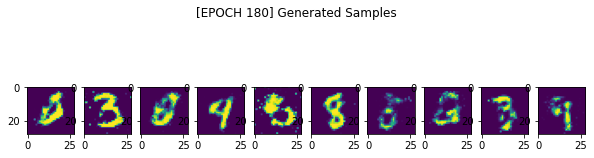

[EPOCH 181] SAMPLED G LOSS : 0.8264433145523071, SAMPLED D LOSS : 0.5318950414657593
[EPOCH 181] SAMPLED G LOSS : 1.132649302482605, SAMPLED D LOSS : 0.5191036462783813
[EPOCH 182] SAMPLED G LOSS : 1.1387948989868164, SAMPLED D LOSS : 0.5445145964622498
[EPOCH 182] SAMPLED G LOSS : 0.8866910338401794, SAMPLED D LOSS : 0.5435798168182373
[EPOCH 183] SAMPLED G LOSS : 0.8377916812896729, SAMPLED D LOSS : 0.5215728282928467
[EPOCH 183] SAMPLED G LOSS : 1.3513824939727783, SAMPLED D LOSS : 0.5338998436927795
[EPOCH 184] SAMPLED G LOSS : 1.179855227470398, SAMPLED D LOSS : 0.5262812376022339
[EPOCH 184] SAMPLED G LOSS : 1.154354214668274, SAMPLED D LOSS : 0.4948117733001709
[EPOCH 185] SAMPLED G LOSS : 1.6818569898605347, SAMPLED D LOSS : 0.495813250541687
[EPOCH 185] SAMPLED G LOSS : 1.0657989978790283, SAMPLED D LOSS : 0.4999721050262451
[EPOCH 186] SAMPLED G LOSS : 1.0129990577697754, SAMPLED D LOSS : 0.5386156439781189
[EPOCH 186] SAMPLED G LOSS : 0.8004093766212463, SAMPLED D LOSS : 0.5

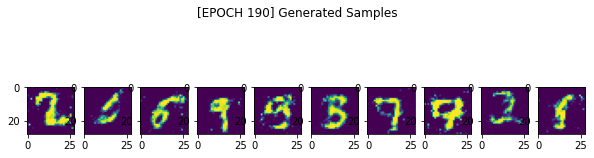

[EPOCH 191] SAMPLED G LOSS : 1.014155387878418, SAMPLED D LOSS : 0.5534273386001587
[EPOCH 191] SAMPLED G LOSS : 0.794796347618103, SAMPLED D LOSS : 0.5504612326622009
[EPOCH 192] SAMPLED G LOSS : 1.5801458358764648, SAMPLED D LOSS : 0.49200940132141113
[EPOCH 192] SAMPLED G LOSS : 1.0105769634246826, SAMPLED D LOSS : 0.5288202166557312
[EPOCH 193] SAMPLED G LOSS : 1.1344667673110962, SAMPLED D LOSS : 0.5725938081741333
[EPOCH 193] SAMPLED G LOSS : 1.272312045097351, SAMPLED D LOSS : 0.5193900465965271
[EPOCH 194] SAMPLED G LOSS : 0.8673062324523926, SAMPLED D LOSS : 0.5468716025352478
[EPOCH 194] SAMPLED G LOSS : 1.0452733039855957, SAMPLED D LOSS : 0.5280759334564209
[EPOCH 195] SAMPLED G LOSS : 1.2426985502243042, SAMPLED D LOSS : 0.5216737389564514
[EPOCH 195] SAMPLED G LOSS : 1.221174716949463, SAMPLED D LOSS : 0.5634626150131226
[EPOCH 196] SAMPLED G LOSS : 1.2434090375900269, SAMPLED D LOSS : 0.5305914282798767
[EPOCH 196] SAMPLED G LOSS : 1.3031573295593262, SAMPLED D LOSS : 0.

In [ ]:
max_epoch = 200

for epoch in tqdm(range(max_epoch)):        
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
        if idx % 200 == 0:
            print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))

    if epoch % 10 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(generator, img_size, dim_z))
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)
        

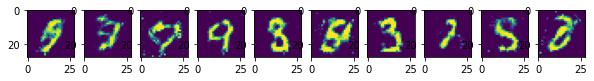

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(generator, img_size, dim_z))
